In [4]:
import torch

print(torch.__version__)

2.0.1+cu118


#### 主要内容
* 一维和二维卷积操作；
* CNN架构的组成构件；
* 使用Pytorch实现深度CNN网络;
* 用于提升泛化性能的数据增强技术；
* 实现用于笑脸识别的CNN分类器；

如下图所示，CNN根据输入图像计算特征图(feature maps)， 其中每个元素来自输入图像中的局部像素块：

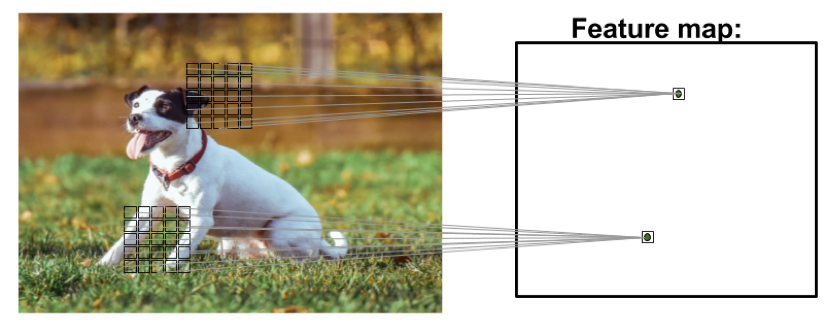

In [1]:
from IPython.display import Image

Image(filename='../Python-MachineLearning/Attached_images/Chapter14/figures/14_01.png', 
      width=450)

其中，这个局部像素块被称为局部感受野(local receptive field). CNN在图像任务上非常出色，得益于如下两个方面：
* **稀疏连接(Sparse connectivity)**：特征图中的元素仅连接到一小块像素；
* **权重共享(Parameter sharing)**：对输入图像的不同块使用相同的权重；

卷积神经网络(Convolutional Neural Networks, CNN)是一种深度学习模型，它在图像和视频识别、分类以及分割任务重非常有效。

对于**稀疏连接**：在传统的全连接网络中，每个神经元都与前一层的所有神经元相连。这种连接方式参数数量非常多，计算复杂度很高。 CNN网络通过使用卷积层来实现稀疏连接。在卷积层中，每个神经元仅与输入数据的一个局部区域相连。这意味着每个卷积核(卷积核就是卷积层中的权重矩阵)只要覆盖输入数据的一个局部区域，而不是整个输入数据。所以这种局部连接方式减少了参数的数量，因为每个卷积核的参数数量远小于全连接层的参数数量，从而降低了计算量和存储需求.

对于**权重共享**：在卷积层中，同一个卷积核对应的权重在整个输入数据上是共享的。也就是说，同一个卷积核在不同的输入区域重复使用。`权重共享的优点是允许模型学习到局部特征的不变性，即相同的特征可以在图像的不同位置被检测到`。

通常，CNN由多个卷积层和子采样层(subsampling layers)组成，最后是一个或多个全连接层。而且，`子采样层通常又被称为池化层(Pooling layers)`,其不具有任何的可学习参数。卷积操作示意如下图：

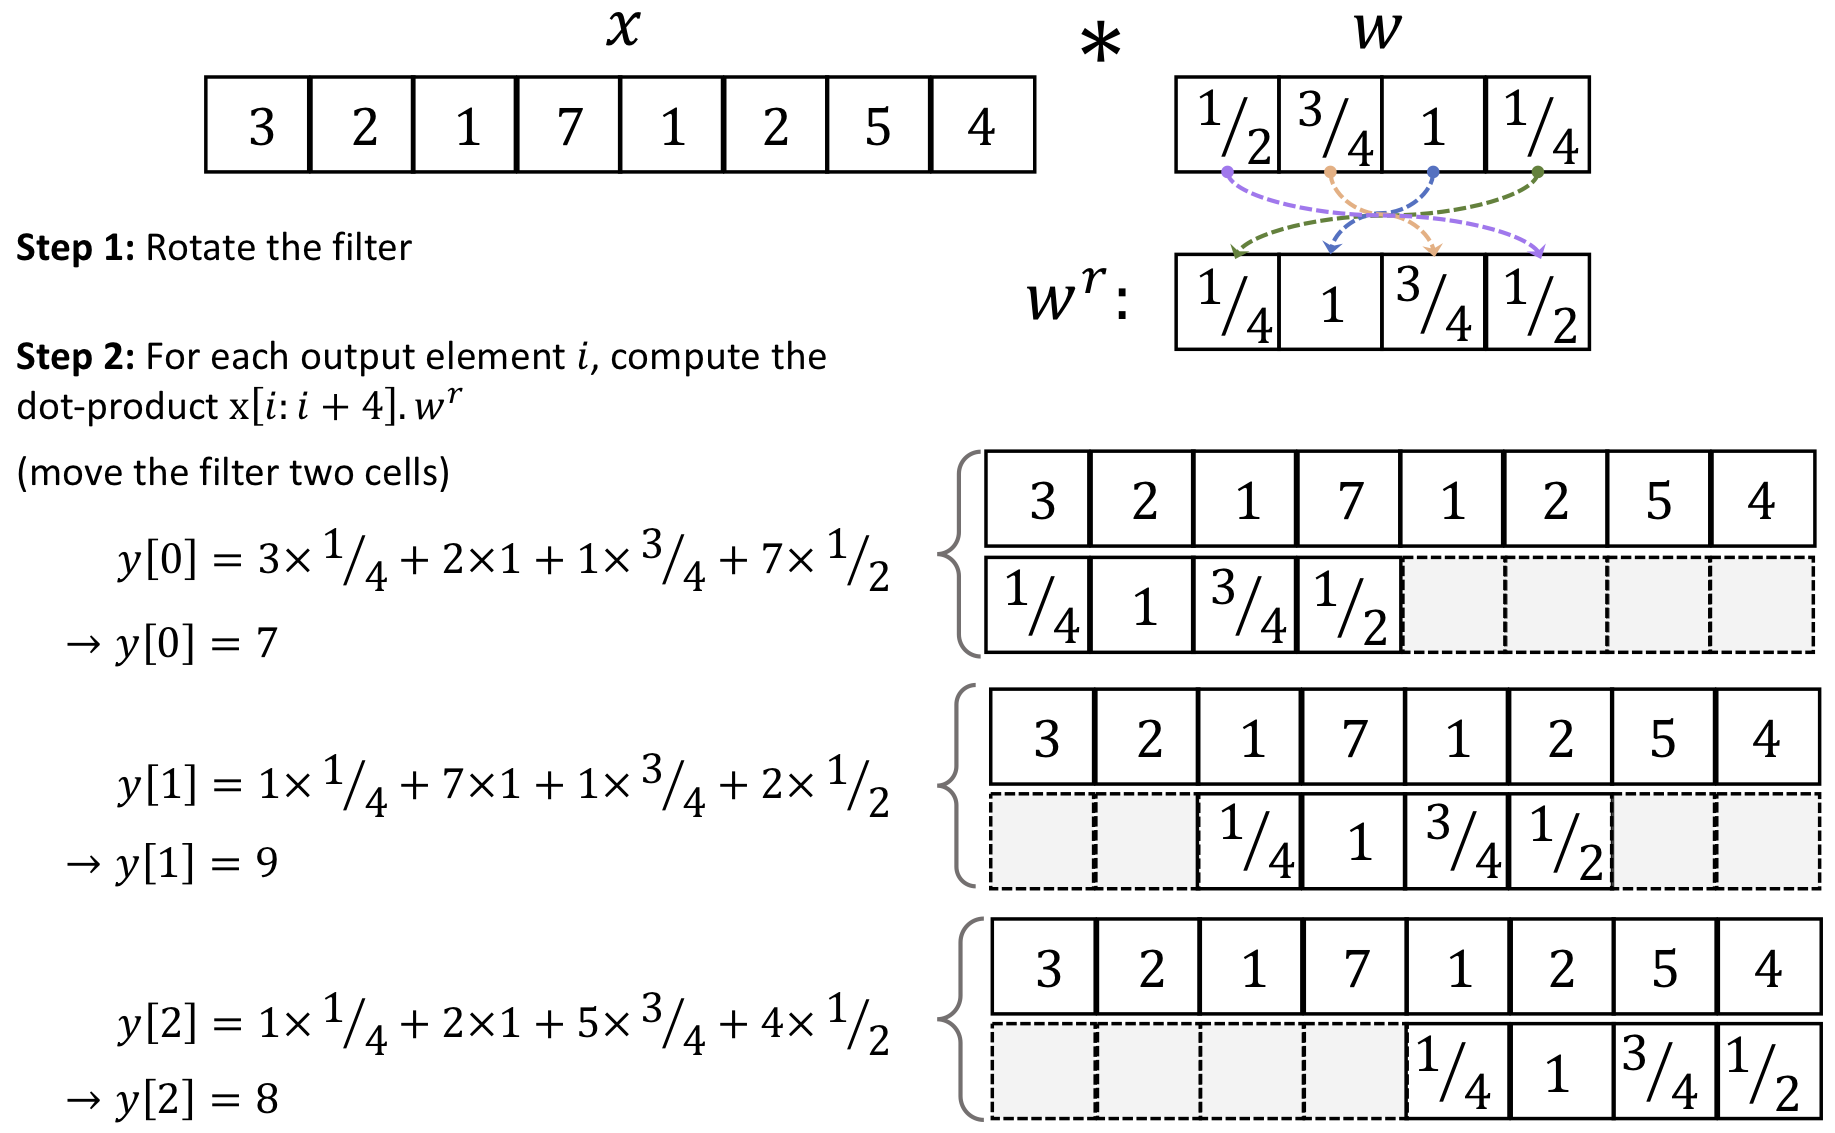

In [2]:
Image(filename='../Python-MachineLearning/Attached_images/Chapter14/figures/14_03.png', 
      width=450)

#### 利用Padding来控制输出特征图的大小

关于Padding的作用：

在神经网络中，特别是在卷积神经网络（CNN）中，padding（填充）有几个重要的原因：

1. **保持特征图的尺寸**：通过在输入数据的边缘添加零值（或其他值），我们可以控制特征图的尺寸。如果没有填充，卷积操作会使特征图的尺寸逐渐减少，这可能导致信息损失，尤其是在多个卷积层后。

2. **防止边缘效应**：卷积操作在边缘的像素受到更少的邻域像素的影响，可能导致边缘特征提取不充分。添加填充可以使卷积核在输入边缘处也能有足够的上下文，从而获得更好的特征学习。

3. **控制输出尺寸**：有时我们希望输出的特征图具有特定的空间尺寸。通过适当地添加填充，可以实现这一目标，而无需调整卷积核的大小或步幅。

4. **提高模型的表现**：在某些情况下，适当的填充可以改善模型的性能，使其更好地泛化到未见过的数据。

如下图是常见的3中Padding模式：

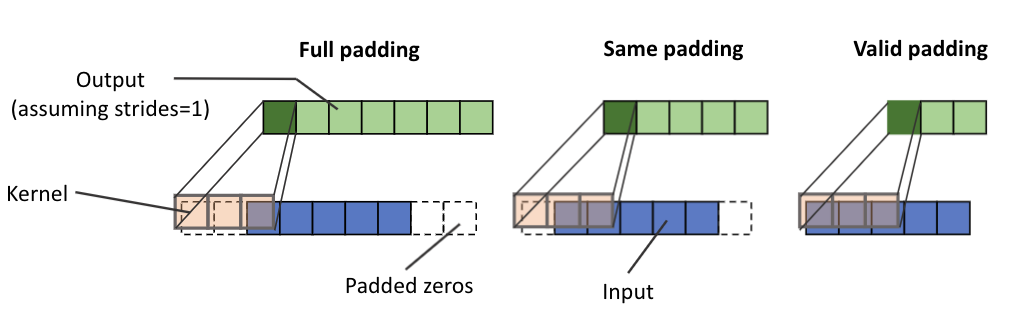

In [3]:
Image(filename='../Python-MachineLearning/Attached_images/Chapter14/figures/14_04.png', 
      width=450)

其中，same padding比较常用，这种方式的一个优点是保持了向量的大小(或者在图像任务中，保留了输入图像的高度和宽度).

valid padding相较于same padding的一个比较大的缺陷是：在具有许多层的NN中，张量的size将大幅减小，这可能会损害网络的性能。

full padding会导致输出大于输入大小，通常用于信号处理中，为了更好地最小化边界效应。